In [ ]:
import os
import glob
import argparse
import textgrids
import numpy as np
from dtw_alignment import *
from distutils.util import strtobool
import pickle as pkl
import json
import re
import random
import math
import copy

import pandas as pd
import seaborn as sns
from tslearn.metrics import dtw_path
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from scipy.stats import pearsonr
from matplotlib.colors import LogNorm
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def read_pickle(pickle_path):
    # -- loading model output pickle
    with open(pickle_path, "rb") as f:
        data = pkl.load(f)

    return data

def load_model_output(exps_dir, filter_by_id, filter_by_condition, attn_scores_id='cross_embed_mha_scores', filter_wrongpred=False):
    # -- retrieving test model output paths
    model_cls_output_paths = glob.glob(f'{exps_dir}/**/model_output/test_classification.pkl', recursive=True)
    model_mha_output_paths = glob.glob(f'{exps_dir}/**/model_output/test_mha_scores.pkl', recursive=True)

    print(f'Found {len(model_cls_output_paths)} model classification output files')
    print(f'Found {len(model_mha_output_paths)} model mha output files')
    # -- loading model output
    sample_ids = []
    target_attn_scores = []
    pred_labels = []
    for model_cls_output_path in model_cls_output_paths:
        batch_cls_model_outputs = read_pickle(model_cls_output_path)
        
        for s, pred, label, sample_id, attn_scores in zip(
            batch_cls_model_outputs['sample_id'],
            batch_cls_model_outputs['preds'],
            batch_cls_model_outputs['labels'],
            batch_cls_model_outputs['sample_id'],
            batch_cls_model_outputs[attn_scores_id],
        ):
            # print(f'Processing sample: {sample_id}, label: {label}, pred: {pred}; Keys in batch_cls_model_outputs: {batch_cls_model_outputs.keys()}')
            # print(f'  Attn scores shape: {np.squeeze(attn_scores, axis=0).shape}')
            # -- filtering by subset, or specific sample
            if filter_by_id in sample_id:
                if filter_by_condition == label:
                    if filter_wrongpred:
                        if pred != label:
                            sample_ids.append( sample_id )
                            loaded_attn_scores = np.squeeze(attn_scores, axis=0)
                            row_sums = np.sum(np.abs(loaded_attn_scores), axis=1)
                            valid_row = row_sums > 1e-10
                            attention_scores_masked = loaded_attn_scores[valid_row, :]
                            target_attn_scores.append( attention_scores_masked )
                            pred_labels.append(pred)
                    else:
                        if pred == label:
                            sample_ids.append( sample_id )
                            loaded_attn_scores = np.squeeze(attn_scores, axis=0)
                            row_sums = np.sum(np.abs(loaded_attn_scores), axis=1)
                            valid_row = row_sums > 1e-10
                            attention_scores_masked = loaded_attn_scores[valid_row, :]
        # 创建有效区域的掩码
                            target_attn_scores.append( attention_scores_masked )
                            pred_labels.append(pred)
                        

    assert len(target_attn_scores) > 0, f'\nNo ID filter matching found for: {filter_by_id}'

    # -- getting metadata regarding informed speech feaures IDs
    # informed_metadata = batch_cls_model_outputs['informed_metadata']
    return sample_ids, target_attn_scores, pred_labels

def get_informed_highlevel_group(current_idx, informed_metadata_bounds):
    for type_inf, (start, end) in informed_metadata_bounds.items():
        if current_idx >= start and current_idx < end:
            return type_inf


exps_dir = './/exps/gita_splits2/M4/combined_set/'
output_dir = '../..//plots/test-oldcat/'
filter_by_id = ''

# -- creating output directory
os.makedirs(output_dir, exist_ok=True)
for subdir in ['figures', 'stats']:
    os.makedirs(os.path.join(output_dir, subdir), exist_ok=True)

filter_by_condition = 0

hc_sample_ids, hc_attn_scores, hc_pred_labels = load_model_output(
    exps_dir,
    filter_by_id,
    filter_by_condition,
    attn_scores_id='attn_scores',
)

print(f'\nConsidering {len(hc_attn_scores)} {"HC" if filter_by_condition == 0 else "PD"} samples based on the ID filter: {filter_by_id}')

filter_by_condition = 1
pd_sample_ids, pd_attn_scores, pd_pred_labels = load_model_output(
    exps_dir,
    filter_by_id,
    filter_by_condition,
    attn_scores_id='attn_scores',
)   
print(f'\nConsidering {len(pd_attn_scores)} {"HC" if filter_by_condition == 0 else "PD"} samples based on the ID filter: {filter_by_id}')



Found 50 model classification output files
Found 0 model mha output files



Considering 3405 HC samples based on the ID filter: 
Found 50 model classification output files
Found 0 model mha output files

Considering 3213 PD samples based on the ID filter: 


In [6]:
# Check if attention scores have been processed through softmax
def check_softmax(attention_scores, axis=1, tolerance=1e-5, padding_mask=None):
    """
    Check if attention scores have been processed through softmax, excluding padding regions
    
    Parameters:
        attention_scores: Attention score matrix
        axis: Axis for summation, 1 for row sum, 0 for column sum
        tolerance: Allowed error range
        padding_mask: Mask indicating padding positions, None means auto-detection through zero values
    
    Returns:
        is_softmax: Whether it has been processed through softmax
    """
    # Automatically identify padding regions (assuming padding parts are all zeros)
    if padding_mask is None:
        # Assume rows or columns that are all zeros are padding
        row_sums = np.sum(np.abs(attention_scores), axis=1)
        col_sums = np.sum(np.abs(attention_scores), axis=0)
        valid_rows = row_sums > 1e-10
        valid_cols = col_sums > 1e-10
        
        # Create mask for valid regions
        attention_scores_masked = attention_scores[valid_rows, :][:, valid_cols]
    else:
        # Use provided mask
        attention_scores_masked = attention_scores[~padding_mask, :][:, ~padding_mask]
    
    # If matrix is empty after masking, return directly
    if attention_scores_masked.size == 0:
        print("Warning: Attention matrix is empty after masking!")
        return {
            'is_softmax': False,
            'sum_values': np.array([]),
            'min_sum': 0,
            'max_sum': 0,
            'mean_sum': 0,
            'std_sum': 0,
            'masked_shape': (0, 0)
        }
    
    # Calculate row or column sums after removing padding
    sum_values = np.sum(attention_scores_masked, axis=axis)
    is_close_to_one = np.allclose(sum_values, 1.0, rtol=tolerance)
    
    return {
        'is_softmax': is_close_to_one,
        'sum_values': sum_values,
        'min_sum': np.min(sum_values) if sum_values.size > 0 else 0,
        'max_sum': np.max(sum_values) if sum_values.size > 0 else 0,
        'mean_sum': np.mean(sum_values) if sum_values.size > 0 else 0,
        'std_sum': np.std(sum_values) if sum_values.size > 0 else 0,
        'masked_shape': attention_scores_masked.shape
    }

# Check HC samples and PD samples separately
def check_all_samples(sample_scores, sample_name):
    print(f"\nChecking {sample_name} samples:")
    
    # Check row sums (axis=1)
    row_results = []
    for i, score in enumerate(sample_scores):
        result = check_softmax(score, axis=1)
        row_results.append(result)
        
    row_softmax_count = sum(r['is_softmax'] for r in row_results)
    print(f"Row sum check: {row_softmax_count}/{len(sample_scores)} samples have row sums approximately equal to 1")
    
    # Calculate mean, min, max of all sample row sums
    all_mean_sums = [r['mean_sum'] for r in row_results]
    print(f"Median of all sample row sums: {np.median(all_mean_sums):.6f}")
    print(f"Minimum of all sample row sums: {np.min([r['min_sum'] for r in row_results]):.6f}")
    print(f"Maximum of all sample row sums: {np.max([r['max_sum'] for r in row_results]):.6f}")

# Check HC samples
if len(hc_attn_scores) > 0:
    check_all_samples(hc_attn_scores, "HC")
    

# Check PD samples
if len(pd_attn_scores) > 0:
    check_all_samples(pd_attn_scores, "PD")


Checking HC samples:
Row sum check: 3405/3405 samples have row sums approximately equal to 1
Median of all sample row sums: 1.000000
Minimum of all sample row sums: 1.000000
Maximum of all sample row sums: 1.000000

Checking PD samples:
Row sum check: 3213/3213 samples have row sums approximately equal to 1
Median of all sample row sums: 1.000000
Minimum of all sample row sums: 1.000000
Maximum of all sample row sums: 1.000000



Visualize PD sample attention dimensions - Bar chart:
Original sample shape: (82, 4)
Sample shape after removing padding: (82, 4)
Valid sample average score shape: (82, 4)
Average scores: [0.05177722 0.1778933  0.11559567 0.65473382]


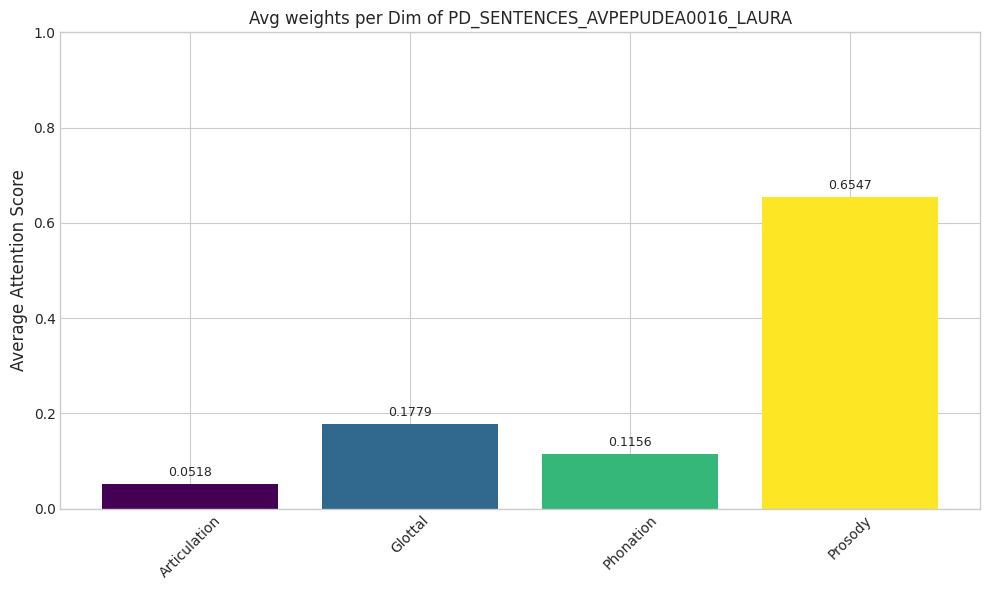


Visualize PD sample attention dimensions - Time series:


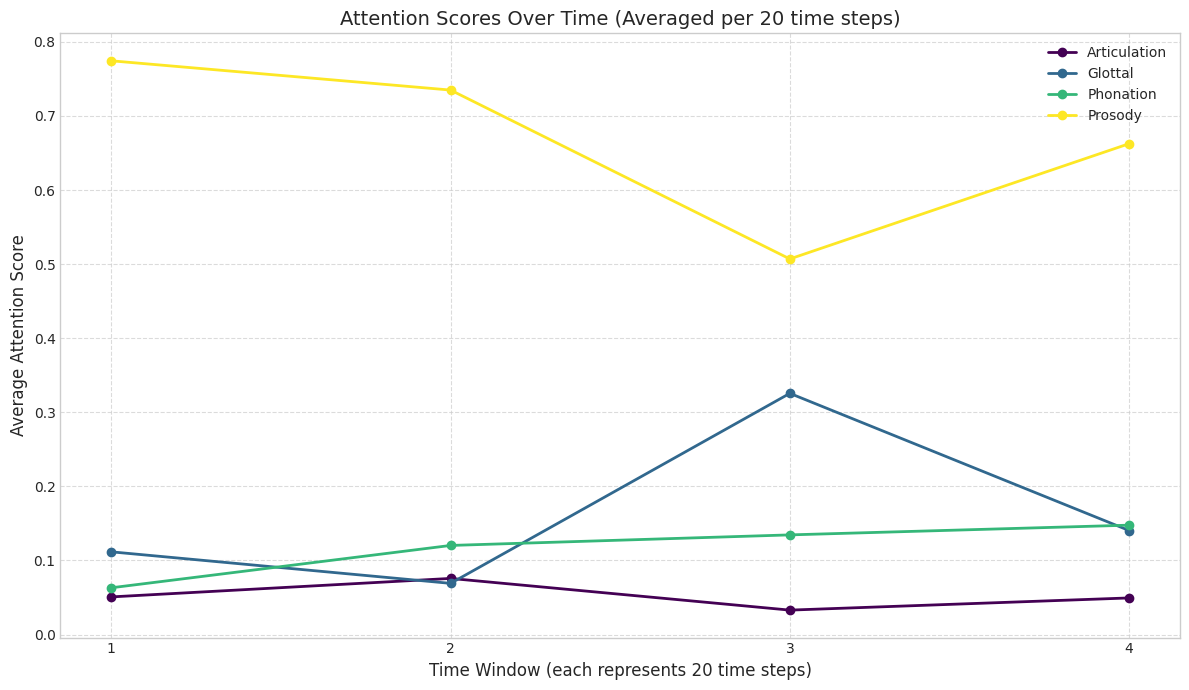

Found sample ID 'PD_DDK_ANALYSIS_AVPEPUDEA0005_PAKATA' at index: 594
PD_DDK_ANALYSIS_AVPEPUDEA0005_PAKATA
Original sample shape: (99, 4)
Sample shape after removing padding: (99, 4)
Valid sample average score shape: (99, 4)
Average scores: [0.18282272 0.09187222 0.65889374 0.06641133]


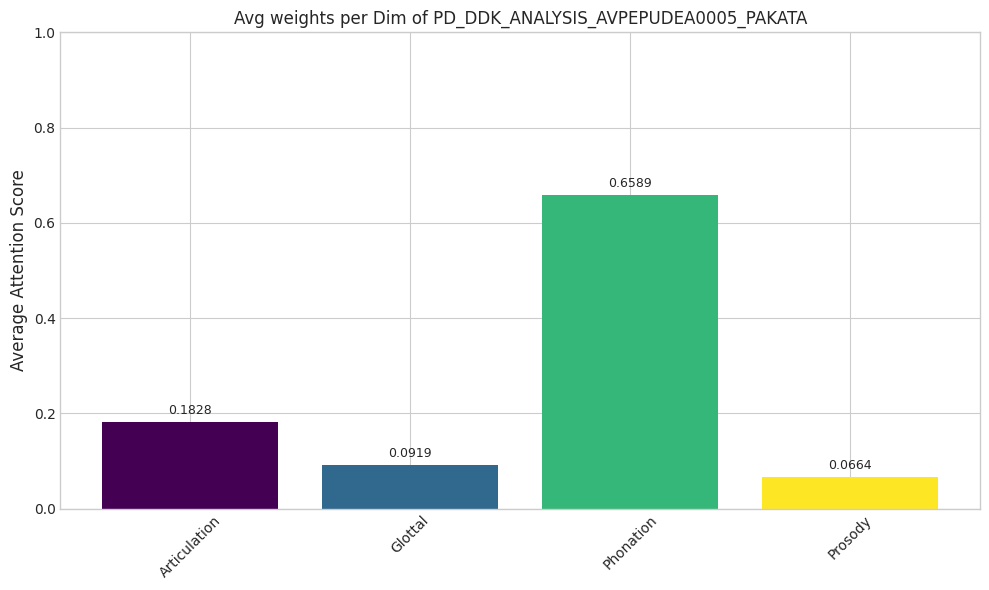

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

def visualize_attention_bar_chart(attn_score, sample_id=None, dimension_names=None, output_path=None):
    """
    Visualize attention scores for individual sample dimensions as bar chart
    
    Parameters:
        attn_score: Attention score matrix of shape (T, D) for individual sample
        sample_id: Sample ID for display in title. Can be string or integer index
        dimension_names: List of dimension names, default is ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
        output_path: Output image path, if None then display image
    """
    if dimension_names is None:
        dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
    
    # Identify non-zero regions (remove padding)
    row_sums = np.sum(np.abs(attn_score), axis=1)
    valid_rows = row_sums > 1e-10
    
    # Remove padding regions
    valid_sample = attn_score[valid_rows, :]
    
    print(f"Original sample shape: {attn_score.shape}")
    print(f"Sample shape after removing padding: {valid_sample.shape}")
    
    T, num_dimensions = valid_sample.shape
    
    # Ensure dimension names count matches
    if len(dimension_names) != num_dimensions:
        print(f"Warning: Number of dimension names ({len(dimension_names)}) does not match attention score dimensions ({num_dimensions})")
        dimension_names = [f"Dimension {i+1}" for i in range(num_dimensions)]
    
    # Set plotting style
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = plt.cm.viridis(np.linspace(0, 1, num_dimensions))
    
    # Figure 1: Bar chart of average attention scores per dimension
    plt.figure(figsize=(10, 6))
    
    # Calculate average score for each dimension
    print(f"Valid sample average score shape: {valid_sample.shape}")
    avg_scores = np.mean(valid_sample, axis=0)
    print(f"Average scores: {avg_scores}")
    
    # Create bar chart
    bars = plt.bar(dimension_names, avg_scores, color=colors)
    
    # Annotate specific values above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    # Set title - decide title text based on sample_id type
    if sample_id is not None:
        plt.title(f'Avg weights per Dim of {sample_id}', fontsize=12)
    else:
        plt.title('Average Attention Weights per Dimension', fontsize=12)
    
    plt.ylabel('Average Attention Score', fontsize=12)
    plt.ylim(0, 1.0)  # Fix y-axis range to 0-1
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save or display image
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return avg_scores  # Return average scores for further analysis


def visualize_attention_time_series(attn_score, dimension_names=None, window_size=20, output_path=None):
    """
    Visualize attention scores over time for individual sample as line chart
    
    Parameters:
        attn_score: Attention score matrix of shape (T, D) for individual sample
        dimension_names: List of dimension names, default is ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
        window_size: Size of time window, default is 20 time steps
        output_path: Output image path, if None then display image
    """
    if dimension_names is None:
        dimension_names = ['Articulation', 'MonoLoudness', 'MonoPitch', 'Rhythm', 'VoiceQuality']
    
    # Identify non-zero regions (remove padding)
    row_sums = np.sum(np.abs(attn_score), axis=1)
    valid_rows = row_sums > 1e-10
    
    # Remove padding regions
    valid_sample = attn_score[valid_rows, :]
    
    T, num_dimensions = valid_sample.shape
    
    # Ensure dimension names count matches
    if len(dimension_names) != num_dimensions:
        print(f"Warning: Number of dimension names ({len(dimension_names)}) does not match attention score dimensions ({num_dimensions})")
        dimension_names = [f"Dimension {i+1}" for i in range(num_dimensions)]
    
    # Set plotting style
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = plt.cm.viridis(np.linspace(0, 1, num_dimensions))
    
    # Figure 2: Line chart of attention scores over time
    plt.figure(figsize=(12, 7))
    
    # Calculate how many windows are needed
    num_windows = max(1, T // window_size)
    
    # Initialize result array
    windowed_scores = np.zeros((num_windows, num_dimensions))
    
    # Calculate average score for each window
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = min(start_idx + window_size, T)
        windowed_scores[i] = np.mean(valid_sample[start_idx:end_idx], axis=0)
    
    # Plot line chart
    x_ticks = np.arange(num_windows) + 1
    
    for i in range(num_dimensions):
        plt.plot(x_ticks, windowed_scores[:, i], 
                 marker='o', linestyle='-', linewidth=2, color=colors[i],
                 label=dimension_names[i])
    
    plt.title(f'Attention Scores Over Time (Averaged per {window_size} time steps)', fontsize=14)
    plt.xlabel(f'Time Window (each represents {window_size} time steps)', fontsize=12)
    plt.ylabel('Average Attention Score', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Set x-axis to integer ticks
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # If there are many windows, adjust x-axis ticks
    if num_windows > 10:
        plt.xticks(np.arange(1, num_windows+1, num_windows//10))
    
    plt.tight_layout()
    
    # Save or display image
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return windowed_scores  # Return time series data for further analysis


    
if len(pd_attn_scores) > 0:
    print("\nVisualize PD sample attention dimensions - Bar chart:")
    sample_index = random.randint(0, len(pd_attn_scores) - 1) 
    visualize_attention_bar_chart(
        pd_attn_scores[sample_index],
        sample_id=pd_sample_ids[sample_index],
        output_path=os.path.join(output_dir, 'figures', f'pd_sample_{pd_sample_ids[sample_index]}_bar.png'),
        dimension_names=['Articulation', 'Glottal', 'Phonation', 'Prosody']
    )
    
    print("\nVisualize PD sample attention dimensions - Time series:")
    visualize_attention_time_series(
        pd_attn_scores[sample_index],
        window_size=20,
        output_path=os.path.join(output_dir, 'figures', f'pd_sample_{sample_index}_time.png'),
        dimension_names=['Articulation', 'Glottal', 'Phonation', 'Prosody']
    )
    
    # Directly specify sample_id
    specify_id = 'PD_DDK_ANALYSIS_AVPEPUDEA0005_PAKATA'
    if specify_id not in pd_sample_ids:
        print(f"Warning: Specified sample ID '{specify_id}' is not in sample list.")
    else:
        idx = pd_sample_ids.index(specify_id)
        print(f"Found sample ID '{specify_id}' at index: {idx}")
        print(pd_sample_ids[idx])
    visualize_attention_bar_chart(
        pd_attn_scores[idx],
        sample_id=specify_id,
        output_path=os.path.join(output_dir, 'figures', f'pd_score_oneutt_{specify_id}.png'),
        dimension_names=['Articulation', 'Glottal', 'Phonation', 'Prosody']
    )